In [1]:
import pandas as pd
import numpy as np
import time
from datetime import datetime

from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [2]:
# 5개의 분리된 엑셀 파일을 불러온다
input_ = []
s_time = time.time()
for i in range(5):
  input_.append(pd.read_excel('/gdrive/My Drive/input_'+str(i+1)+'.xlsx'))
print('Elapsed :', time.time() - s_time)

Elapsed : 41.29081702232361


In [3]:
# 전처리 1 : (연월종목 X 입력변수) 의 2차원 Dataframe 생성

# 5개 각각의 엑셀 파일을 2차원 dataframe으로 정리한 뒤 5개를 1개로 병합
num_date = 58

new_input = []
for input_data in input_: # 각 Excel 파일마다 반복

  for i in range(1, num_date): # 날짜 -> string
    input_data['Code'][i] = input_data['Code'][i].strftime('%Y%m')[2:]

  # 날짜 리스트
  date = input_data['Code'].tolist()[1:]

  num_input = 28 # 입력 변수 갯수
  num_stock = (input_data.shape[1] - 1)//num_input # 한 엑셀 파일당 종목 갯수

  # 종목별 데이터 쪼개기
  input_data_list = []
  for i in range(num_stock):
    input_data_list.append(input_data.iloc[:, num_input*i+1 : num_input*(i+1)+1])
  
  # 입력 변수 리스트
  input_list = input_data_list[0].loc[0,:].tolist()

  # 종목 당 (연월종목 X 입력변수) Dataframe 구성
  for i in range(num_stock):
    # 종목 코드 추출
    stock_code = input_data_list[i].columns[0]

    # 날짜 + 종목의 새 Index 구성
    new_date = []
    
    for t in date:
      new_date.append(t + stock_code)

    # Column 설정
    input_data_list[i].columns = input_list
    input_data_list[i].drop([0], inplace=True)

    # Index 설정
    input_data_list[i].index = new_date
  
    # Dataset X, y 시간 조정
    # 주식 종목 당 X(t) <-> y(t+1) 이 연결되도록 한다.
    # -> X : 가장 최근 값 삭제 / y : 가장 과거 값 삭제
    
    output_data = input_data_list[i][['월간수익률']][1:]
    input_data_list[i] = input_data_list[i][:-1]
    input_data_list[i]['월간수익률(t+1)'] = output_data['월간수익률'].tolist()

  # 종목 Dataframe 결합
  new_input.append(pd.concat(input_data_list))

# 엑셀 별 Dataframe 결합
all_input = pd.concat(new_input)
all_input

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,수정주가,월간평균거래량,월간수익률,20일거래량회전율,60일변동성(표준편차),20일평균대차거래체결량비중,월간평균 공매도수량/거래량,외국인지분율,유동주식비율(보통주),유동자산,비유동자산,부채총계,자본금,기타포괄이익누계액,비지배주주지분,Cash Earnings,영업활동으로인한현금흐름,투자활동으로인한현금흐름,CAPEX,배당금,자본의증감,현금의증가,매출원가,매출총이익,판매비와관리비,인건비및복리후생비,영업이익,당기순이익,월간수익률(t+1)
1504A000020,8330,218978,10.92,0.007854,0.020248,0,0.72,6.36,61.99,1.35015e+08,1.82172e+08,8.70693e+07,27931470,2.94674e+06,NaN,1.74731e+07,1.98331e+07,-979732,885504,2.2345e+06,-2.35441e+06,1.22662e+07,1.26622e+08,9.65794e+07,9.17664e+07,31392013,4.81297e+06,5.60865e+06,12.48
1505A000020,9370,332579,12.48,0.010915,0.029854,0,0.4,7,61.99,1.35015e+08,1.82172e+08,8.70693e+07,27931470,2.94674e+06,NaN,1.74731e+07,1.98331e+07,-979732,885504,2.2345e+06,-2.35441e+06,1.22662e+07,1.26622e+08,9.65794e+07,9.17664e+07,31392013,4.81297e+06,5.60865e+06,-3.20
1506A000020,9070,295146,-3.2,0.008875,0.033701,0,0.88,8.21,61.99,1.35015e+08,1.82172e+08,8.70693e+07,27931470,2.94674e+06,NaN,1.74731e+07,1.98331e+07,-979732,885504,2.2345e+06,-2.35441e+06,1.22662e+07,1.26622e+08,9.65794e+07,9.17664e+07,31392013,4.81297e+06,5.60865e+06,-10.03
1507A000020,8160,596820,-10.03,0.017638,0.040963,0,1.39,8.54,61.99,1.35015e+08,1.82172e+08,8.70693e+07,27931470,2.94674e+06,NaN,1.74731e+07,1.98331e+07,-979732,885504,2.2345e+06,-2.35441e+06,1.22662e+07,1.26622e+08,9.65794e+07,9.17664e+07,31392013,4.81297e+06,5.60865e+06,-12.99
1508A000020,7100,130112,-12.99,0.004658,0.036095,0.02,2.45,8.56,61.99,1.35015e+08,1.82172e+08,8.70693e+07,27931470,2.94674e+06,NaN,1.74731e+07,1.98331e+07,-979732,885504,2.2345e+06,-2.35441e+06,1.22662e+07,1.26622e+08,9.65794e+07,9.17664e+07,31392013,4.81297e+06,5.60865e+06,-1.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1907A950180,18800,98679,-24.35,0.004333,0.04108,0.01,0.1,79.5,24.34,305367430,15621087,17396691,108942915,-386004,173271,31624410,32821083,-412681,979478,542366,174857749,202713290,21133984,80935428,33770911,8975658,47164517,31169202,-7.71
1908A950180,17350,62520,-7.71,0.003066,0.034115,0.01,0.57,78.99,64.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.86
1909A950180,17500,61914,0.86,0.002951,0.031125,0,0.36,79.35,64.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.57
1910A950180,19000,60167,8.57,0.002937,0.028425,0,0.28,80.74,64.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-13.69


In [4]:
# 전처리 2: 결측 값 제거
# y 값 (월간수익률, 표준편차)을 다른 값으로 채워넣기엔 성능 저하가 예측되기에 제거한다.

# (월간수익률, 표준편차) 이 NaN 인 Row 제거
all_input = all_input[pd.notnull(all_input['월간수익률'])]
all_input = all_input[pd.notnull(all_input['월간수익률(t+1)'])]

# 종목 종류 수 재설정
num_stock = all_input.shape[0]//num_date 
all_input.isnull().sum() # Column 당 NaN 값 갯수

수정주가                  0
월간평균거래량               0
월간수익률                 0
20일거래량회전율            99
60일변동성(표준편차)        677
20일평균대차거래체결량비중    15885
월간평균 공매도수량/거래량    25395
외국인지분율                8
유동주식비율(보통주)       13177
유동자산              16829
비유동자산             17240
부채총계              13955
자본금               13955
기타포괄이익누계액         29242
비지배주주지분           62719
Cash Earnings     14560
영업활동으로인한현금흐름      13964
투자활동으로인한현금흐름      14080
CAPEX             15038
배당금               14623
자본의증감             14207
현금의증가             13955
매출원가              19609
매출총이익             14699
판매비와관리비           13964
인건비및복리후생비         14558
영업이익              13829
당기순이익             13820
월간수익률(t+1)            0
dtype: int64

In [5]:
# NaN 값이 너무 많은 Column 제거
all_input.drop(['비지배주주지분'], axis='columns', inplace=True)
num_input -= 1 # Input 수 재설정

# 2번째로 NaN 값이 제일 많은 Column (기타포괄이익누계액)이 NaN인 Row 제거 
all_input = all_input[pd.notnull(all_input['기타포괄이익누계액'])]

all_input.isnull().sum() # NaN 값이 특정 Row에 몰려 있음을 확인할 수 있다.

수정주가                 0
월간평균거래량              0
월간수익률                0
20일거래량회전율           34
60일변동성(표준편차)       263
20일평균대차거래체결량비중    2323
월간평균 공매도수량/거래량    9088
외국인지분율               0
유동주식비율(보통주)          0
유동자산              2837
비유동자산             2837
부채총계                 0
자본금                  0
기타포괄이익누계액            0
Cash Earnings      116
영업활동으로인한현금흐름         0
투자활동으로인한현금흐름        55
CAPEX              449
배당금                618
자본의증감              216
현금의증가                0
매출원가              4698
매출총이익              680
판매비와관리비              0
인건비및복리후생비          430
영업이익                 0
당기순이익                0
월간수익률(t+1)           0
dtype: int64

In [6]:
# 전처리 3: Test Set 분리
# 나머지 Data 이용, 19년 11월의 월 이율 및 변동성을 예측한다

# Index에 따라 오름차순 정렬
all_input = all_input.sort_index()

# 19년 12월 정보의 첫 Index 구하기
for i, idx in enumerate(all_input.index): 
    if idx[:4] == '1911':
        # 19년 12월 기준으로 DataFrame 나누기
        test_data = all_input.iloc[i:]
        all_input = all_input.iloc[:i]
        break

# NaN 값 분포 체크
test_data.isnull().sum()

수정주가                0
월간평균거래량             0
월간수익률               0
20일거래량회전율           1
60일변동성(표준편차)        6
20일평균대차거래체결량비중     14
월간평균 공매도수량/거래량    161
외국인지분율              0
유동주식비율(보통주)         0
유동자산               50
비유동자산              50
부채총계                0
자본금                 0
기타포괄이익누계액           0
Cash Earnings       1
영업활동으로인한현금흐름        0
투자활동으로인한현금흐름        2
CAPEX              10
배당금                 3
자본의증감               0
현금의증가               0
매출원가              102
매출총이익              13
판매비와관리비             0
인건비및복리후생비           8
영업이익                0
당기순이익               0
월간수익률(t+1)          0
dtype: int64

In [7]:
# Test Set의 NaN 값은 다른 값으로 채울 수 없으므로 NaN 값을 갖는 Row를 제거한다
test_data = test_data.dropna(axis=0)
test_data

,수정주가,월간평균거래량,월간수익률,20일거래량회전율,60일변동성(표준편차),20일평균대차거래체결량비중,월간평균 공매도수량/거래량,외국인지분율,유동주식비율(보통주),유동자산,비유동자산,부채총계,자본금,기타포괄이익누계액,Cash Earnings,영업활동으로인한현금흐름,투자활동으로인한현금흐름,CAPEX,배당금,자본의증감,현금의증가,매출원가,매출총이익,판매비와관리비,인건비및복리후생비,영업이익,당기순이익,월간수익률(t+1)
1911A000020,8190,116931,4.6,0.004218,0.015546,0,2.53,4.66,61.39,2.35457e+08,1.40572e+08,7.5154e+07,27931470,1.66704e+06,2.08785e+07,1.3285e+07,-1.11784e+07,4.79732e+06,3.31293e+06,0,-2.83533e+06,1.85418e+08,1.21732e+08,1.11814e+08,39869357,9.91775e+06,9.39385e+06,1.46
1911A000040,1054,1349349,-34.61,0.007456,0.039392,0.01,0.26,16.17,38.49,5.26991e+07,9.13821e+07,1.08871e+08,9.4722e+07,1.27046e+07,-3.7398e+07,-7.07868e+06,7.34069e+06,541351,0,0,-1.5e+07,1.33567e+08,-987674,23662766,7630612,-24650440,-4.10417e+07,-14.15
1911A000050,9890,13654,-1.1,0.000518,0.008453,0,0.52,1.93,37.74,264861016,1105881476,629189292,13707635,-3096980,79454075,66875285,-45096923,35885928,3371475,-5654143,6788110,244396020,99496064,67475534,3361173,32020530,43621631,-6.17
1911A000070,65800,6947,3.78,0.000816,0.015482,0.03,8.19,8.81,45.09,1.25948e+09,2.33004e+09,1.56001e+09,44341645,2.22672e+07,1.53771e+08,2.18938e+08,-3.22323e+08,1.5777e+08,2.54458e+07,-517830,5.88264e+07,2.02513e+09,4.63431e+08,3.84054e+08,110922000,7.93763e+07,6.20439e+07,1.82
1911A000080,28250,352616,-0.7,0.004952,0.018776,0.17,19.85,9.59,43.59,7.82268e+08,2.48859e+09,2.23766e+09,368842230,9690640,1.0558e+08,2.82518e+07,-6.60146e+07,160704038,5.56843e+07,12,-1.46748e+08,1.16322e+09,8.71843e+08,7.83596e+08,2.25292e+08,8.82466e+07,-4.2395e+07,2.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1911A900140,4540,215468,1.45,0.003894,0.021269,0,0.21,3.3,52.22,327677679,351170265,352918814,14796811,3456129,-35905808,26463277,-35767327,4006481,0,3867607,-15003934,337957942,25790654,55997713,20150234,-30207059,-55600092,-8.37
1911A900250,1870,1605494,-6.5,0.024131,0.023794,0.01,1.17,26.93,78.15,145201005,153561113,33741366,36280209,36851,29113328,18923746,-37903035,32116237,0,0,-35125945,45779117,38813356,10278947,2147062,28534409,22563142,-6.15
1911A900260,480,5790067,-21.18,0.042619,0.030968,0,0.3,48.91,57.35,276896974,54470909,74437486,152274399,2057735,6023087,69843501,-6961592,811309,0,40301528,105701550,78602733,19119717,14711520,4582235,4408197,2774421,-3.33
1911A900270,1145,8672579,6.51,0.103264,0.039304,0.02,0.44,28.31,72.58,279603646,57011903,58750072,69021818,2687807,36604796,55018440,573772,70292,0,0,53394554,161726594,59519309,15611663,2761011,43907646,32571320,-6.99


In [8]:
# 나머지 NaN 값을 해당 Column의 평균으로 채운다
# 모델 성능 저하 요소
for column in all_input.columns:
    all_input[column].fillna(all_input[column].mean(), inplace=True)
all_input.isnull().sum()

수정주가              0
월간평균거래량           0
월간수익률             0
20일거래량회전율         0
60일변동성(표준편차)      0
20일평균대차거래체결량비중    0
월간평균 공매도수량/거래량    0
외국인지분율            0
유동주식비율(보통주)       0
유동자산              0
비유동자산             0
부채총계              0
자본금               0
기타포괄이익누계액         0
Cash Earnings     0
영업활동으로인한현금흐름      0
투자활동으로인한현금흐름      0
CAPEX             0
배당금               0
자본의증감             0
현금의증가             0
매출원가              0
매출총이익             0
판매비와관리비           0
인건비및복리후생비         0
영업이익              0
당기순이익             0
월간수익률(t+1)        0
dtype: int64

In [9]:
# 전처리 4: Data Normalization
# Column별 평균 0, 분산 1로 맞춰준다.
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# X, y 분리
y_data = all_input[['월간수익률(t+1)']]
x_data = all_input.drop(['월간수익률(t+1)'], axis='columns')

y_data.index = list(all_input.index)

# 평균 0, 분산 1로 Scaling, y_data의 경우 상관관계 분석을 위한 Frame을 따로 둔다
sscaler = StandardScaler()
sscaler.fit(x_data)

x_data = pd.DataFrame(sscaler.transform(x_data), columns=x_data.columns)
x_data.index = list(all_input.index) # Index 손실 방지

sscaler.fit(y_data)
y_data_norm = pd.DataFrame(sscaler.transform(y_data), columns=y_data.columns)
y_data_norm.index = list(all_input.index)

x_data

,수정주가,월간평균거래량,월간수익률,20일거래량회전율,60일변동성(표준편차),20일평균대차거래체결량비중,월간평균 공매도수량/거래량,외국인지분율,유동주식비율(보통주),유동자산,비유동자산,부채총계,자본금,기타포괄이익누계액,Cash Earnings,영업활동으로인한현금흐름,투자활동으로인한현금흐름,CAPEX,배당금,자본의증감,현금의증가,매출원가,매출총이익,판매비와관리비,인건비및복리후생비,영업이익,당기순이익
1504A000020,-0.230195,-0.153864,0.669440,-0.211044,-0.494034,-0.356069,-5.397647e-01,-0.122832,0.260560,-1.156652e-01,-1.252837e-01,-0.118082,-0.142107,-0.034396,-0.082488,-0.068240,0.111773,-0.098992,-0.077494,-0.046346,0.016855,-1.772675e-01,-8.581688e-02,-0.084577,-0.106059,-0.084451,-0.073093
1504A000040,-0.261715,0.747356,-0.894163,-0.046201,0.318594,-0.263713,-5.306153e-01,0.287410,-0.111314,-1.275839e-01,-1.409423e-01,-0.117949,0.066798,-0.040319,-0.102615,-0.093972,0.101245,-0.095219,-0.088940,-0.032294,-0.015243,-1.857477e-01,-1.213733e-01,-0.129312,-0.191863,-0.102560,-0.097854
1504A000050,0.011861,-0.251028,2.225305,-0.384955,0.021566,-0.356069,-1.859868e-01,-0.500489,-0.601274,-1.216479e-01,2.663846e-02,-0.090498,-0.191862,-0.043125,-0.064530,-0.055092,0.083618,-0.057492,-0.081918,-0.032294,-0.051346,-1.544295e-01,-8.386886e-02,-0.102165,-0.200299,-0.054816,-0.060734
1504A000060,-0.149329,0.049535,1.605667,-0.256809,-0.563996,0.752203,2.998015e+00,0.310805,-0.340819,-4.980488e-15,1.356030e-15,0.525354,-0.054484,0.795163,0.051527,0.546919,-0.624675,-0.089236,0.115742,-0.032294,0.049446,2.696242e-15,6.051992e-15,0.240540,0.574059,0.106373,0.109128
1504A000070,1.038602,-0.242583,0.666216,-0.346031,-0.332391,-0.263713,-5.946613e-01,0.107772,-0.621272,8.297293e-02,1.495528e-01,-0.060454,-0.084706,0.038002,0.002268,-0.022392,0.071088,0.004426,-0.006781,-0.041597,-0.282243,1.119134e-01,3.072072e-02,0.041698,0.089708,0.003988,0.007648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1910A900260,-0.334779,0.580732,-0.889004,-0.059507,1.274841,-0.356069,-6.617572e-01,4.028053,0.039626,-8.413458e-02,-1.441490e-01,-0.118694,0.292837,-0.036213,-0.089921,-0.035506,0.107060,-0.099072,-0.088940,0.208248,0.482434,-1.857525e-01,-1.149462e-01,-0.131360,-0.199222,-0.084802,-0.076253
1910A900270,-0.328467,2.376606,-0.706530,1.536186,1.580947,0.013355,-6.373587e-01,2.143110,0.764804,-8.353307e-02,-1.437737e-01,-0.119455,0.001624,-0.034925,-0.070067,-0.045210,0.112997,-0.099878,-0.088940,-0.032294,0.221793,-1.710645e-01,-9.975360e-02,-0.130814,-0.205550,-0.050524,-0.043027
1910A950130,-0.314515,-0.099536,0.042709,-0.143203,1.921676,-0.356069,-7.014047e-01,-0.132023,0.770042,-1.399110e-01,-1.457228e-01,-0.120276,-0.232957,-0.052279,-0.105022,-0.081499,0.115061,-0.096636,-0.088940,0.026854,-0.036768,-1.936954e-01,-1.185987e-01,-0.129700,-0.196239,-0.095603,-0.102380
1910A950140,-0.276046,-0.244078,-0.477632,-0.396490,-0.525741,-0.356069,-2.478530e-14,0.318324,-0.030845,-1.299966e-01,-1.455751e-01,-0.119675,-0.219694,-0.040570,-0.089411,-0.073292,0.109103,-0.094632,-0.088940,-0.032294,-0.022759,-1.806537e-01,-1.124119e-01,-0.128688,-0.185708,-0.082773,-0.076817


In [10]:
y_data['Label'] = y_data[y_data['월간수익률(t+1)'] > 3]
y_data['Label'].fillna(0, inplace=True)
y_data['Label'][y_data['Label'] > 3] = 1

y_data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

,월간수익률(t+1),Label
1504A000020,12.48,1.0
1504A000040,-8.91,0.0
1504A000050,-7.25,0.0
1504A000060,1.75,0.0
1504A000070,5.88,1.0
...,...,...
1910A900260,-21.18,0.0
1910A900270,6.51,1.0
1910A950130,2.37,0.0
1910A950140,-11.12,0.0


In [11]:
# Test Data X, y Data 분리
y_test = test_data[['월간수익률(t+1)']]
x_test = test_data.drop(['월간수익률(t+1)'], axis='columns')

# Test Data Scaling
sscaler = StandardScaler()
sscaler.fit(x_test)

x_test = pd.DataFrame(sscaler.transform(x_test), columns=x_test.columns)
x_test.index = list(test_data.index)

x_test

,수정주가,월간평균거래량,월간수익률,20일거래량회전율,60일변동성(표준편차),20일평균대차거래체결량비중,월간평균 공매도수량/거래량,외국인지분율,유동주식비율(보통주),유동자산,비유동자산,부채총계,자본금,기타포괄이익누계액,Cash Earnings,영업활동으로인한현금흐름,투자활동으로인한현금흐름,CAPEX,배당금,자본의증감,현금의증가,매출원가,매출총이익,판매비와관리비,인건비및복리후생비,영업이익,당기순이익
1911A000020,-0.224997,-0.268163,0.344893,-0.312020,-0.710681,-0.327387,-0.010307,-0.278996,0.274987,-0.092717,-0.131256,-0.137205,-0.114572,-0.006671,-0.073120,-0.080436,0.092017,-0.103206,-0.059032,-0.093157,-0.042835,-0.154467,-0.061347,-0.051169,-0.047201,-0.080420,-0.043806
1911A000040,-0.337969,0.211236,-2.430912,-0.247601,0.857237,-0.278636,-0.716203,0.801159,-1.013105,-0.126822,-0.137472,-0.132664,0.202551,0.034412,-0.113614,-0.096442,0.107143,-0.107866,-0.071642,-0.093157,-0.126215,-0.162612,-0.114352,-0.107137,-0.182331,-0.125666,-0.127902
1911A000050,-0.198085,-0.308337,-0.058628,-0.385632,-1.177059,-0.327387,-0.635351,-0.535193,-1.055292,-0.087230,-0.009270,-0.062593,-0.182107,-0.024404,-0.032418,-0.038312,0.064314,-0.069162,-0.058809,-0.162773,0.023126,-0.145203,-0.070951,-0.079320,-0.200227,-0.051490,0.013265
1911A000070,0.687035,-0.310946,0.286843,-0.379703,-0.714889,-0.181133,1.749769,0.110460,-0.641865,0.098379,0.145426,0.062759,-0.036656,0.070006,0.019222,0.081214,-0.162108,0.064305,0.025218,-0.099532,0.379811,0.134505,0.086239,0.121680,0.250620,0.010493,0.043982
1911A000080,0.092575,-0.176484,-0.030311,-0.297418,-0.498303,0.501386,5.375650,0.183659,-0.726238,0.009325,0.165463,0.154019,1.504080,0.023194,-0.014264,-0.068671,0.047230,0.067518,0.140323,-0.093156,-1.029249,-0.000879,0.262640,0.375353,0.730010,0.022103,-0.130158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1911A900140,-0.282781,-0.229833,0.121894,-0.318466,-0.334384,-0.327387,-0.731751,-0.406625,-0.240812,-0.075507,-0.104643,-0.099798,-0.176936,-0.000012,-0.112577,-0.070077,0.071934,-0.104072,-0.071642,-0.045537,-0.126242,-0.130507,-0.102786,-0.086607,-0.129855,-0.132939,-0.152176
1911A900250,-0.325050,0.310874,-0.440912,0.084148,-0.168360,-0.278636,-0.433222,1.810930,1.217713,-0.109560,-0.129615,-0.142782,-0.074932,-0.012739,-0.067398,-0.076003,0.070190,-0.073290,-0.071642,-0.093157,-0.264164,-0.176401,-0.097161,-0.115634,-0.205316,-0.056053,-0.021848
1911A900260,-0.347056,1.938633,-1.480158,0.451966,0.303343,-0.327387,-0.703764,3.873641,0.047743,-0.084984,-0.142137,-0.137301,0.475811,-0.005217,-0.083442,-0.035979,0.095461,-0.107571,-0.071642,0.403052,0.701105,-0.171245,-0.105667,-0.112820,-0.195109,-0.087632,-0.054843
1911A900270,-0.336528,3.059902,0.480109,1.658495,0.851450,-0.229884,-0.660229,1.940436,0.904408,-0.084479,-0.141815,-0.139414,0.080526,-0.002872,-0.062192,-0.047632,0.101616,-0.108382,-0.071642,-0.093157,0.342579,-0.158188,-0.088218,-0.112248,-0.202742,-0.035931,-0.005160


In [12]:
y_test['Label'] = y_test[y_test['월간수익률(t+1)'] > 3]
y_test['Label'].fillna(0, inplace=True)
y_test['Label'][y_test['Label'] > 3] = 1

y_test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

,월간수익률(t+1),Label
1911A000020,1.46,0.0
1911A000040,-14.15,0.0
1911A000050,-6.17,0.0
1911A000070,1.82,0.0
1911A000080,2.65,0.0
...,...,...
1911A900140,-8.37,0.0
1911A900250,-6.15,0.0
1911A900260,-3.33,0.0
1911A900270,-6.99,0.0


In [13]:
y_data = y_data[['Label']]
y_test = y_test[['Label']]

In [14]:
# 전처리 5: Feature Analysis & Selection

# Column 이름 변경
x_data.columns = ['x'+str(i) for i in range(27)]
x_test.columns = x_data.columns

x_data

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26
1504A000020,-0.230195,-0.153864,0.669440,-0.211044,-0.494034,-0.356069,-5.397647e-01,-0.122832,0.260560,-1.156652e-01,-1.252837e-01,-0.118082,-0.142107,-0.034396,-0.082488,-0.068240,0.111773,-0.098992,-0.077494,-0.046346,0.016855,-1.772675e-01,-8.581688e-02,-0.084577,-0.106059,-0.084451,-0.073093
1504A000040,-0.261715,0.747356,-0.894163,-0.046201,0.318594,-0.263713,-5.306153e-01,0.287410,-0.111314,-1.275839e-01,-1.409423e-01,-0.117949,0.066798,-0.040319,-0.102615,-0.093972,0.101245,-0.095219,-0.088940,-0.032294,-0.015243,-1.857477e-01,-1.213733e-01,-0.129312,-0.191863,-0.102560,-0.097854
1504A000050,0.011861,-0.251028,2.225305,-0.384955,0.021566,-0.356069,-1.859868e-01,-0.500489,-0.601274,-1.216479e-01,2.663846e-02,-0.090498,-0.191862,-0.043125,-0.064530,-0.055092,0.083618,-0.057492,-0.081918,-0.032294,-0.051346,-1.544295e-01,-8.386886e-02,-0.102165,-0.200299,-0.054816,-0.060734
1504A000060,-0.149329,0.049535,1.605667,-0.256809,-0.563996,0.752203,2.998015e+00,0.310805,-0.340819,-4.980488e-15,1.356030e-15,0.525354,-0.054484,0.795163,0.051527,0.546919,-0.624675,-0.089236,0.115742,-0.032294,0.049446,2.696242e-15,6.051992e-15,0.240540,0.574059,0.106373,0.109128
1504A000070,1.038602,-0.242583,0.666216,-0.346031,-0.332391,-0.263713,-5.946613e-01,0.107772,-0.621272,8.297293e-02,1.495528e-01,-0.060454,-0.084706,0.038002,0.002268,-0.022392,0.071088,0.004426,-0.006781,-0.041597,-0.282243,1.119134e-01,3.072072e-02,0.041698,0.089708,0.003988,0.007648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1910A900260,-0.334779,0.580732,-0.889004,-0.059507,1.274841,-0.356069,-6.617572e-01,4.028053,0.039626,-8.413458e-02,-1.441490e-01,-0.118694,0.292837,-0.036213,-0.089921,-0.035506,0.107060,-0.099072,-0.088940,0.208248,0.482434,-1.857525e-01,-1.149462e-01,-0.131360,-0.199222,-0.084802,-0.076253
1910A900270,-0.328467,2.376606,-0.706530,1.536186,1.580947,0.013355,-6.373587e-01,2.143110,0.764804,-8.353307e-02,-1.437737e-01,-0.119455,0.001624,-0.034925,-0.070067,-0.045210,0.112997,-0.099878,-0.088940,-0.032294,0.221793,-1.710645e-01,-9.975360e-02,-0.130814,-0.205550,-0.050524,-0.043027
1910A950130,-0.314515,-0.099536,0.042709,-0.143203,1.921676,-0.356069,-7.014047e-01,-0.132023,0.770042,-1.399110e-01,-1.457228e-01,-0.120276,-0.232957,-0.052279,-0.105022,-0.081499,0.115061,-0.096636,-0.088940,0.026854,-0.036768,-1.936954e-01,-1.185987e-01,-0.129700,-0.196239,-0.095603,-0.102380
1910A950140,-0.276046,-0.244078,-0.477632,-0.396490,-0.525741,-0.356069,-2.478530e-14,0.318324,-0.030845,-1.299966e-01,-1.455751e-01,-0.119675,-0.219694,-0.040570,-0.089411,-0.073292,0.109103,-0.094632,-0.088940,-0.032294,-0.022759,-1.806537e-01,-1.124119e-01,-0.128688,-0.185708,-0.082773,-0.076817


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


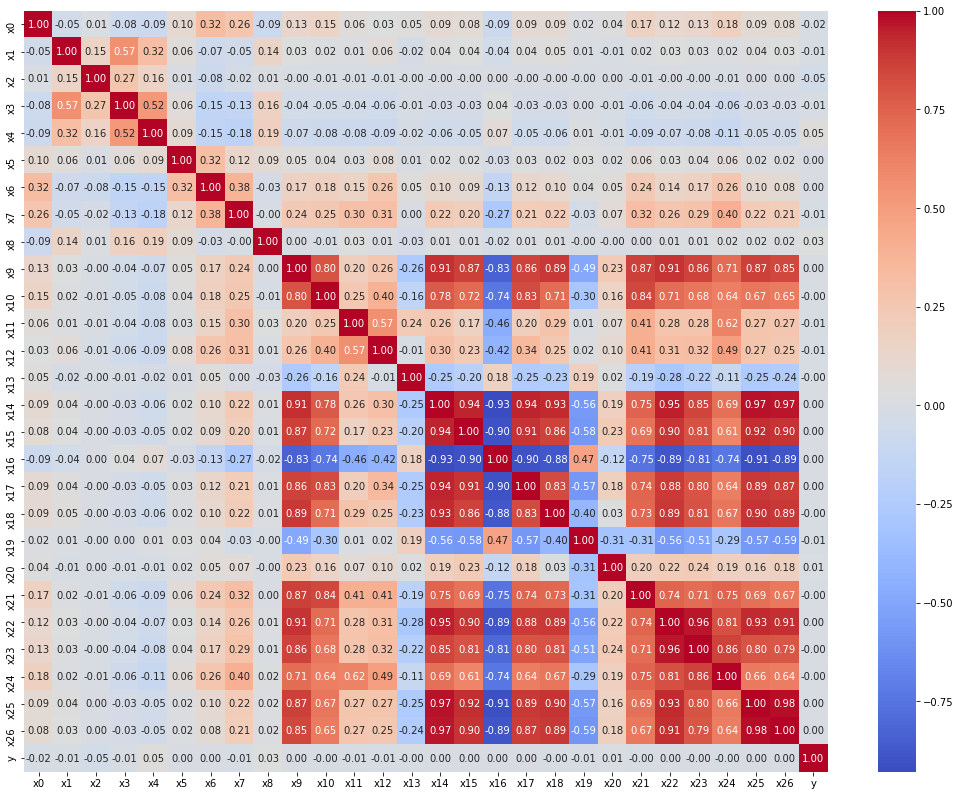

In [15]:
# Pearson : 선형 관계 체크
# 각 변수 간 선형관계 체크, 계수의 절댓값이 0.85이상인 경우 변수 중복으로 취급, 제거
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = [18, 14]

all_data = pd.DataFrame(x_data, copy=True) 
all_data['y'] = y_data['Label']

sns.heatmap(all_data.corr(method='pearson'),annot=True, fmt = ".2f", cmap = "coolwarm")
# y0(월 수익률)의 경우 선형 관계를 갖는 Feature가 없음을 알 수 있다.

In [16]:
# x10, x14 ~ x18, x21 ~ x26 제거
# x10(비유동자산) x14(Cash Earnings) x15(영업활동으로인한현금흐름), x16(투자활동으로인한현금흐름) x17(CAPEX) x18(배당금)
# x21(매출원가) x22(매출총이익) x23(판매비와관리비) x24(인건비및복리후생비) x25(영업이익) x25(당기순이익)

x_data = x_data[['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x11', 'x12', 'x13', 'x19', 'x20']]
x_test = x_test[['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x11', 'x12', 'x13', 'x19', 'x20']]
num_input = 15

# Column 이름 변경
x_data.columns = ['x'+str(i) for i in range(num_input)]
x_test.columns = x_data.columns

x_data

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14
1504A000020,-0.230195,-0.153864,0.669440,-0.211044,-0.494034,-0.356069,-5.397647e-01,-0.122832,0.260560,-1.156652e-01,-0.118082,-0.142107,-0.034396,-0.046346,0.016855
1504A000040,-0.261715,0.747356,-0.894163,-0.046201,0.318594,-0.263713,-5.306153e-01,0.287410,-0.111314,-1.275839e-01,-0.117949,0.066798,-0.040319,-0.032294,-0.015243
1504A000050,0.011861,-0.251028,2.225305,-0.384955,0.021566,-0.356069,-1.859868e-01,-0.500489,-0.601274,-1.216479e-01,-0.090498,-0.191862,-0.043125,-0.032294,-0.051346
1504A000060,-0.149329,0.049535,1.605667,-0.256809,-0.563996,0.752203,2.998015e+00,0.310805,-0.340819,-4.980488e-15,0.525354,-0.054484,0.795163,-0.032294,0.049446
1504A000070,1.038602,-0.242583,0.666216,-0.346031,-0.332391,-0.263713,-5.946613e-01,0.107772,-0.621272,8.297293e-02,-0.060454,-0.084706,0.038002,-0.041597,-0.282243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1910A900260,-0.334779,0.580732,-0.889004,-0.059507,1.274841,-0.356069,-6.617572e-01,4.028053,0.039626,-8.413458e-02,-0.118694,0.292837,-0.036213,0.208248,0.482434
1910A900270,-0.328467,2.376606,-0.706530,1.536186,1.580947,0.013355,-6.373587e-01,2.143110,0.764804,-8.353307e-02,-0.119455,0.001624,-0.034925,-0.032294,0.221793
1910A950130,-0.314515,-0.099536,0.042709,-0.143203,1.921676,-0.356069,-7.014047e-01,-0.132023,0.770042,-1.399110e-01,-0.120276,-0.232957,-0.052279,0.026854,-0.036768
1910A950140,-0.276046,-0.244078,-0.477632,-0.396490,-0.525741,-0.356069,-2.478530e-14,0.318324,-0.030845,-1.299966e-01,-0.119675,-0.219694,-0.040570,-0.032294,-0.022759


In [17]:
# 전처리 6 : Dataset 분리
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(x_data, y_data, test_size=0.2, random_state=1)
print(X_train.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(72711, 15)
(18178, 15)
(72711, 1)
(18178, 1)


In [18]:
# 모델 선택 1: Model Initialization
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [19]:
# Random Forest
RFC = RandomForestClassifier(max_depth=7, n_estimators=200, criterion='gini', random_state=1, n_jobs=-1)

s_time = time.time()
RFC.fit(X_train, y_train)
RFC_train = RFC.predict(X_train)
RFC_valid = RFC.predict(X_valid)
print('Elapsed :', time.time() - s_time)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Elapsed : 17.834594249725342


In [20]:
DTC = DecisionTreeClassifier(max_depth=4)

s_time = time.time()
DTC.fit(X_train, y_train)
DTC_train = DTC.predict(X_train) 
DTC_valid = DTC.predict(X_valid)
print('Elapsed :', time.time() - s_time)

Elapsed : 0.4602971076965332


In [21]:
KNC = KNeighborsClassifier(n_neighbors=30)

s_time = time.time()
KNC.fit(X_train, y_train)
KNC_train = KNC.predict(X_train)
KNC_valid = KNC.predict(X_valid)
print('Elapsed :', time.time() - s_time)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  after removing the cwd from sys.path.


Elapsed : 91.22922873497009


In [22]:
LRC = LogisticRegression(l1_ratio=0.5)

s_time = time.time()
LRC.fit(X_train, y_train)
LRC_train = LRC.predict(X_train)
LRC_valid = LRC.predict(X_valid)
print('Elapsed :', time.time() - s_time)

Elapsed : 0.18819308280944824


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [23]:
GBC = GradientBoostingClassifier(max_depth=5, n_estimators=100)

s_time = time.time()
GBC.fit(X_train, y_train)
GBC_train = GBC.predict(X_train)
GBC_valid = GBC.predict(X_valid)
print('Elapsed :', time.time() - s_time)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Elapsed : 54.24312448501587


In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix

print('Train Accuracy')
print('RFC : ', accuracy_score(RFC_train, y_train))
print('DTC : ', accuracy_score(DTC_train, y_train))
print('KNC : ', accuracy_score(KNC_train, y_train))
print('LRC : ', accuracy_score(LRC_train, y_train))
print('GBC : ', accuracy_score(GBC_train, y_train))

print('\nValid Accuracy')
print('RFC : ', accuracy_score(RFC_valid, y_valid))
print('DTC : ', accuracy_score(DTC_valid, y_valid))
print('KNC : ', accuracy_score(KNC_valid, y_valid))
print('LRC : ', accuracy_score(LRC_valid, y_valid))
print('GBC : ', accuracy_score(GBC_valid, y_valid))


Train Accuracy
RFC :  0.6733781683651717
DTC :  0.6713839721637717
KNC :  0.6768301907551815
LRC :  0.6680419743917702
GBC :  0.6814099654797761

Valid Accuracy
RFC :  0.6710859280448894
DTC :  0.6706458356254813
KNC :  0.6644845417537683
LRC :  0.6689954890527011
GBC :  0.6720761359885576


In [25]:
RFC_pred = RFC.predict(x_test)
DTC_pred = DTC.predict(x_test)
KNC_pred = KNC.predict(x_test)
LRC_pred = LRC.predict(x_test)
GBC_pred = GBC.predict(x_test)

In [26]:
print('Prediction Accuracy')
print('RFC : ', accuracy_score(RFC_pred, y_test))
print('DTC : ', accuracy_score(DTC_pred, y_test))
print('KNC : ', accuracy_score(KNC_pred, y_test))
print('LRC : ', accuracy_score(LRC_pred, y_test))
print('GBC : ', accuracy_score(GBC_pred, y_test))

Prediction Accuracy
RFC :  0.5589430894308943
DTC :  0.5602981029810298
KNC :  0.5602981029810298
LRC :  0.5602981029810298
GBC :  0.5474254742547425


In [31]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
XGBC = XGBClassifier()

XGB_param_grid = {'max_depth': [2, 3, 4], 'subsample': [0.8], 'n_estimators': [100, 150]}
GridSearch = GridSearchCV(estimator=XGBC, param_grid=XGB_param_grid, scoring='roc_auc', n_jobs=8, cv=5,
                       refit=True, return_train_score=True)

s_time = time.time()
GridSearch.fit(X_train, y_train)
print('Elapsed :', time.time() - s_time)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Elapsed : 185.49922347068787


In [32]:
GSCV_Result = pd.DataFrame(GridSearch.cv_results_)
GSCV_Result[['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']]

,params,mean_train_score,mean_test_score,rank_test_score
0,"{'max_depth': 2, 'n_estimators': 100, 'subsamp...",0.599404,0.584625,6
1,"{'max_depth': 2, 'n_estimators': 150, 'subsamp...",0.605840,0.585128,4
2,"{'max_depth': 3, 'n_estimators': 100, 'subsamp...",0.617454,0.586418,1
3,"{'max_depth': 3, 'n_estimators': 150, 'subsamp...",0.629073,0.586351,2
4,"{'max_depth': 4, 'n_estimators': 100, 'subsamp...",0.643378,0.584925,5
5,"{'max_depth': 4, 'n_estimators': 150, 'subsamp...",0.662787,0.585582,3


In [33]:
XGBC_pred = GridSearch.predict(x_test)
accuracy_score(XGBC_pred, y_test)

0.5616531165311653

In [ ]:
from lightgbm import LGBMClassifier
